In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fb96cd7dd0a59fa54774232d16c7991bccbd63cdc7e2692fc0770f40fcd1245b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch.nn as nn
from torchvision.models import efficientnet_v2_s

class EfficientNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2Classifier, self).__init__()
        self.model = efficientnet_v2_s(weights="DEFAULT")  # You can use other variants: m, l
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [8]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [9]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [11]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [13]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=69e4e7fcebb38a9301c800dddab181db6fc50bb4bb7e422235c1b8ce407fd070
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=0568fc9b88af5f3582b90c871658bf0146d9dc5d056d3631ba5e9c54398601e9
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = EfficientNetV2Classifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 175MB/s]


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                       | #elements or shape   |
|:---------------------------|:---------------------|
| model                      | 20.2M                |
|  module                    |  20.2M               |
|   module.model             |   20.2M              |
|    module.model.features   |    20.2M             |
|    module.model.classifier |    3.8K              |
Total FLOPs: 2.91 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Train Loss: 0.3180, Accuracy: 0.5865, Precision: 0.5588, Recall: 0.5865, F1 Score: 0.5666


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Validation Inference Time: 3.76 sec, Peak GPU Memory: 1090.90 MB
Validation Loss: 0.2794, Accuracy: 0.6783, Precision: 0.6330, Recall: 0.6783, F1 Score: 0.6293
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.2159, Accuracy: 0.7395, Precision: 0.7354, Recall: 0.7395, F1 Score: 0.6859


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.71 sec, Peak GPU Memory: 1169.94 MB
Validation Loss: 0.2530, Accuracy: 0.7383, Precision: 0.7250, Recall: 0.7383, F1 Score: 0.7137
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Train Loss: 0.1682, Accuracy: 0.8485, Precision: 0.8463, Recall: 0.8485, F1 Score: 0.8397


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1172.41 MB
Validation Loss: 0.2269, Accuracy: 0.7417, Precision: 0.7389, Recall: 0.7417, F1 Score: 0.7392
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.1343, Accuracy: 0.9005, Precision: 0.8999, Recall: 0.9005, F1 Score: 0.8979


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Validation Inference Time: 2.62 sec, Peak GPU Memory: 1168.94 MB
Validation Loss: 0.2482, Accuracy: 0.7100, Precision: 0.7502, Recall: 0.7100, F1 Score: 0.7207
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Train Loss: 0.1115, Accuracy: 0.9590, Precision: 0.9586, Recall: 0.9590, F1 Score: 0.9586


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Validation Inference Time: 2.68 sec, Peak GPU Memory: 1168.94 MB
Validation Loss: 0.2470, Accuracy: 0.7367, Precision: 0.7483, Recall: 0.7367, F1 Score: 0.7351
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.1015, Accuracy: 0.9765, Precision: 0.9764, Recall: 0.9765, F1 Score: 0.9764


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.72 sec, Peak GPU Memory: 1168.94 MB
Validation Loss: 0.2530, Accuracy: 0.7500, Precision: 0.7479, Recall: 0.7500, F1 Score: 0.7388
Best model updated based on validation accuracy
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


Train Loss: 0.0952, Accuracy: 0.9855, Precision: 0.9854, Recall: 0.9855, F1 Score: 0.9854


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.75 sec, Peak GPU Memory: 1171.27 MB
Validation Loss: 0.2526, Accuracy: 0.7350, Precision: 0.7519, Recall: 0.7350, F1 Score: 0.7381
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Train Loss: 0.0911, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.72 sec, Peak GPU Memory: 1171.27 MB
Validation Loss: 0.2393, Accuracy: 0.7467, Precision: 0.7688, Recall: 0.7467, F1 Score: 0.7539
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0899, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 1171.27 MB
Validation Loss: 0.2355, Accuracy: 0.7500, Precision: 0.7748, Recall: 0.7500, F1 Score: 0.7575
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


Train Loss: 0.0879, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Validation Inference Time: 2.92 sec, Peak GPU Memory: 1171.27 MB
Validation Loss: 0.2386, Accuracy: 0.7467, Precision: 0.7644, Recall: 0.7467, F1 Score: 0.7523
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0856, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1171.27 MB
Validation Loss: 0.2332, Accuracy: 0.7617, Precision: 0.7641, Recall: 0.7617, F1 Score: 0.7618
Best model updated based on validation accuracy
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Train Loss: 0.0852, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1174.92 MB
Validation Loss: 0.2311, Accuracy: 0.7667, Precision: 0.7732, Recall: 0.7667, F1 Score: 0.7685
Best model updated based on validation accuracy
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0845, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Validation Inference Time: 2.76 sec, Peak GPU Memory: 1169.73 MB
Validation Loss: 0.2335, Accuracy: 0.7817, Precision: 0.7823, Recall: 0.7817, F1 Score: 0.7810
Best model updated based on validation accuracy
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0833, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Validation Inference Time: 2.93 sec, Peak GPU Memory: 1172.79 MB
Validation Loss: 0.2297, Accuracy: 0.7667, Precision: 0.7800, Recall: 0.7667, F1 Score: 0.7712
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0831, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Validation Inference Time: 2.93 sec, Peak GPU Memory: 1172.79 MB
Validation Loss: 0.2399, Accuracy: 0.7700, Precision: 0.7733, Recall: 0.7700, F1 Score: 0.7675
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0819, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Validation Inference Time: 2.76 sec, Peak GPU Memory: 1172.79 MB
Validation Loss: 0.2283, Accuracy: 0.7833, Precision: 0.7803, Recall: 0.7833, F1 Score: 0.7811
Best model updated based on validation accuracy
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0813, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2269, Accuracy: 0.7817, Precision: 0.7801, Recall: 0.7817, F1 Score: 0.7803
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0801, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2285, Accuracy: 0.7750, Precision: 0.7801, Recall: 0.7750, F1 Score: 0.7757
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0798, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2307, Accuracy: 0.7783, Precision: 0.7787, Recall: 0.7783, F1 Score: 0.7758
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0783, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2341, Accuracy: 0.7717, Precision: 0.7722, Recall: 0.7717, F1 Score: 0.7695
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0774, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2313, Accuracy: 0.7750, Precision: 0.7723, Recall: 0.7750, F1 Score: 0.7725
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0772, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.82 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2293, Accuracy: 0.7800, Precision: 0.7806, Recall: 0.7800, F1 Score: 0.7787
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0758, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Validation Inference Time: 3.00 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2278, Accuracy: 0.7750, Precision: 0.7806, Recall: 0.7750, F1 Score: 0.7759
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0760, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Validation Inference Time: 2.92 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2265, Accuracy: 0.7800, Precision: 0.7771, Recall: 0.7800, F1 Score: 0.7773
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0753, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.86 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2250, Accuracy: 0.7783, Precision: 0.7764, Recall: 0.7783, F1 Score: 0.7764
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0746, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2261, Accuracy: 0.7783, Precision: 0.7772, Recall: 0.7783, F1 Score: 0.7763
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0741, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2229, Accuracy: 0.7800, Precision: 0.7823, Recall: 0.7800, F1 Score: 0.7799
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Train Loss: 0.0728, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.72 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2244, Accuracy: 0.7800, Precision: 0.7764, Recall: 0.7800, F1 Score: 0.7767
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0728, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2214, Accuracy: 0.7717, Precision: 0.7786, Recall: 0.7717, F1 Score: 0.7732
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0721, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1169.27 MB
Validation Loss: 0.2184, Accuracy: 0.7800, Precision: 0.7800, Recall: 0.7800, F1 Score: 0.7790
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Test Inference Time: 2.73 sec, Peak GPU Memory: 1250.85 MB
Test Loss: 0.2128, Accuracy: 0.7833, Precision: 0.7803, Recall: 0.7833, F1 Score: 0.7811
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       117
           1       0.86      0.87      0.87       393
           2       0.65      0.70      0.67        90

    accuracy                           0.78       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.78      0.78      0.78       600



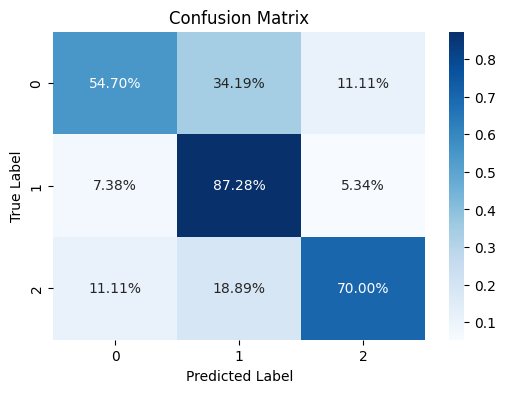

Test Sensitivity: 0.9220, Test Specificity: 0.6154


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


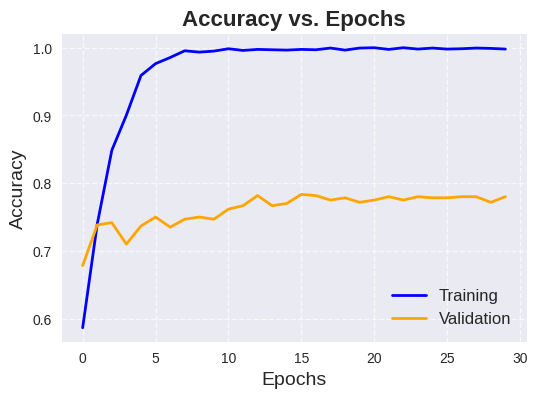

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


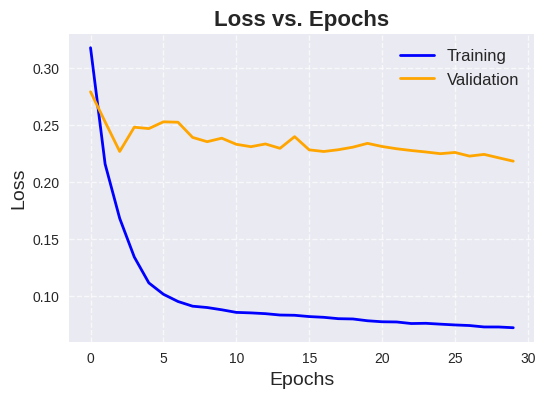

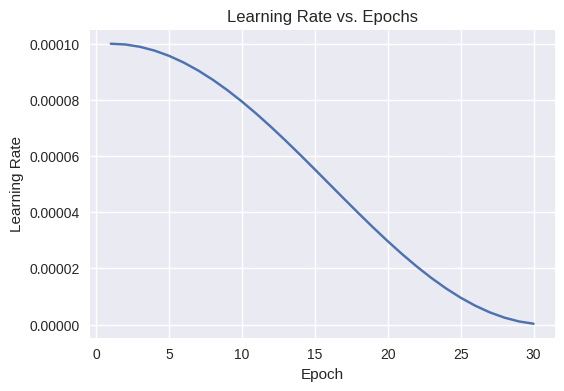

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0752, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.81 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2194, Accuracy: 0.7567, Precision: 0.7726, Recall: 0.7567, F1 Score: 0.7623
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0726, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2415, Accuracy: 0.7717, Precision: 0.7644, Recall: 0.7717, F1 Score: 0.7618
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0733, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Validation Inference Time: 2.91 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2405, Accuracy: 0.7717, Precision: 0.7710, Recall: 0.7717, F1 Score: 0.7643
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0725, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.88 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2781, Accuracy: 0.7100, Precision: 0.7594, Recall: 0.7100, F1 Score: 0.7227
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0703, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Validation Inference Time: 2.95 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2308, Accuracy: 0.7667, Precision: 0.7708, Recall: 0.7667, F1 Score: 0.7684
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0703, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Validation Inference Time: 2.76 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2249, Accuracy: 0.7583, Precision: 0.7565, Recall: 0.7583, F1 Score: 0.7566
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0715, Accuracy: 0.9895, Precision: 0.9895, Recall: 0.9895, F1 Score: 0.9895


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation Inference Time: 2.80 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2323, Accuracy: 0.7433, Precision: 0.7491, Recall: 0.7433, F1 Score: 0.7445
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0681, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.88 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2355, Accuracy: 0.7683, Precision: 0.7662, Recall: 0.7683, F1 Score: 0.7623
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0674, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2409, Accuracy: 0.7517, Precision: 0.7620, Recall: 0.7517, F1 Score: 0.7482
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0664, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2449, Accuracy: 0.7350, Precision: 0.7704, Recall: 0.7350, F1 Score: 0.7442
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0656, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2408, Accuracy: 0.7483, Precision: 0.7676, Recall: 0.7483, F1 Score: 0.7531
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0644, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Validation Inference Time: 2.75 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2253, Accuracy: 0.7633, Precision: 0.7695, Recall: 0.7633, F1 Score: 0.7652
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0639, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2321, Accuracy: 0.7600, Precision: 0.7585, Recall: 0.7600, F1 Score: 0.7561
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0631, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2389, Accuracy: 0.7433, Precision: 0.7685, Recall: 0.7433, F1 Score: 0.7512
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Train Loss: 0.0629, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Validation Inference Time: 2.92 sec, Peak GPU Memory: 1248.53 MB
Validation Loss: 0.2293, Accuracy: 0.7850, Precision: 0.7884, Recall: 0.7850, F1 Score: 0.7799
Best model updated based on validation accuracy
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0617, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2350, Accuracy: 0.7750, Precision: 0.7816, Recall: 0.7750, F1 Score: 0.7711
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0613, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2326, Accuracy: 0.7567, Precision: 0.7746, Recall: 0.7567, F1 Score: 0.7568
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0596, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2389, Accuracy: 0.7667, Precision: 0.7699, Recall: 0.7667, F1 Score: 0.7617
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0596, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.81 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2331, Accuracy: 0.7700, Precision: 0.7901, Recall: 0.7700, F1 Score: 0.7747
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0585, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2594, Accuracy: 0.7267, Precision: 0.7603, Recall: 0.7267, F1 Score: 0.7337
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0581, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2343, Accuracy: 0.7617, Precision: 0.7808, Recall: 0.7617, F1 Score: 0.7668
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0570, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2389, Accuracy: 0.7667, Precision: 0.7849, Recall: 0.7667, F1 Score: 0.7692
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0564, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2438, Accuracy: 0.7283, Precision: 0.7603, Recall: 0.7283, F1 Score: 0.7377
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0561, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation Inference Time: 2.80 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2395, Accuracy: 0.7617, Precision: 0.7696, Recall: 0.7617, F1 Score: 0.7636
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0559, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.89 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2353, Accuracy: 0.7683, Precision: 0.7873, Recall: 0.7683, F1 Score: 0.7719
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0542, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.72 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2296, Accuracy: 0.7733, Precision: 0.7832, Recall: 0.7733, F1 Score: 0.7738
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Train Loss: 0.0534, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Validation Inference Time: 2.94 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2263, Accuracy: 0.7767, Precision: 0.7785, Recall: 0.7767, F1 Score: 0.7754
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0531, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Validation Inference Time: 2.98 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2245, Accuracy: 0.7767, Precision: 0.7812, Recall: 0.7767, F1 Score: 0.7762
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0523, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2288, Accuracy: 0.7717, Precision: 0.7760, Recall: 0.7717, F1 Score: 0.7659
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0512, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2259, Accuracy: 0.7683, Precision: 0.7763, Recall: 0.7683, F1 Score: 0.7662
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


Train Loss: 0.0507, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Validation Inference Time: 3.02 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2223, Accuracy: 0.7700, Precision: 0.7757, Recall: 0.7700, F1 Score: 0.7668
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0495, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Validation Inference Time: 2.92 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2186, Accuracy: 0.7700, Precision: 0.7851, Recall: 0.7700, F1 Score: 0.7726
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0489, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Validation Inference Time: 3.02 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2159, Accuracy: 0.7683, Precision: 0.7785, Recall: 0.7683, F1 Score: 0.7688
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0482, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2151, Accuracy: 0.7750, Precision: 0.7848, Recall: 0.7750, F1 Score: 0.7762
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0477, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Validation Inference Time: 2.73 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2144, Accuracy: 0.7667, Precision: 0.7805, Recall: 0.7667, F1 Score: 0.7701
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0471, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.81 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2120, Accuracy: 0.7800, Precision: 0.7851, Recall: 0.7800, F1 Score: 0.7782
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0461, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2095, Accuracy: 0.7717, Precision: 0.7817, Recall: 0.7717, F1 Score: 0.7727
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0455, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Validation Inference Time: 2.94 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2118, Accuracy: 0.7683, Precision: 0.7832, Recall: 0.7683, F1 Score: 0.7722
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0448, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.86 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2067, Accuracy: 0.7833, Precision: 0.7876, Recall: 0.7833, F1 Score: 0.7831
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0440, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1250.96 MB
Validation Loss: 0.2107, Accuracy: 0.7700, Precision: 0.7830, Recall: 0.7700, F1 Score: 0.7718
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Test Inference Time: 3.09 sec, Peak GPU Memory: 1330.78 MB
Test Loss: 0.1891, Accuracy: 0.7850, Precision: 0.7884, Recall: 0.7850, F1 Score: 0.7799
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       117
           1       0.86      0.88      0.87       393
           2       0.59      0.79      0.68        90

    accuracy                           0.79       600
   macro avg       0.72      0.71      0.70       600
weighted avg       0.79      0.79      0.78       600



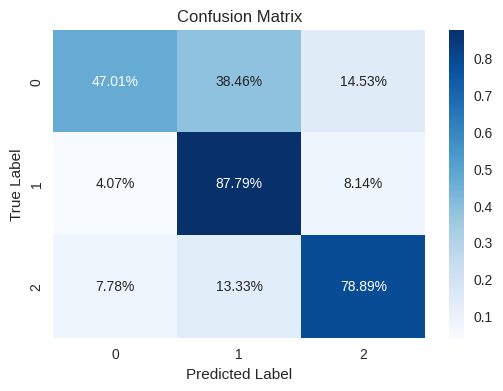

Test Sensitivity: 0.9557, Test Specificity: 0.5500


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


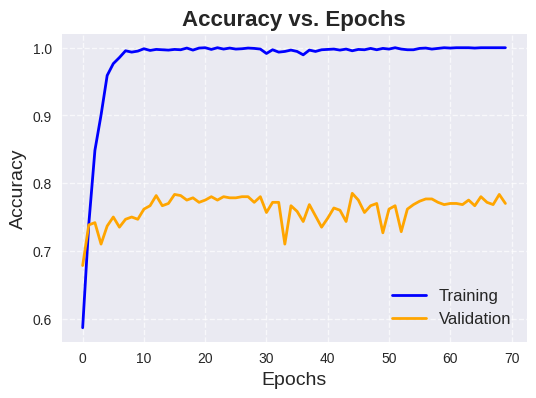

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


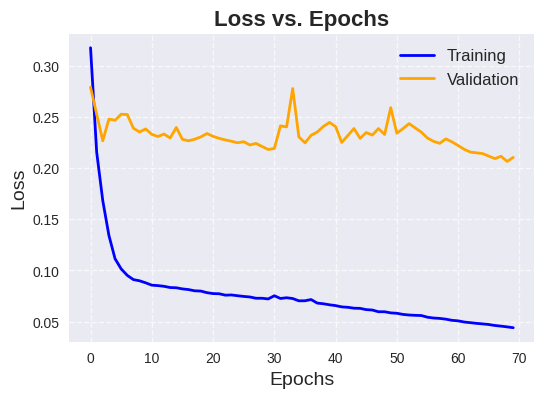

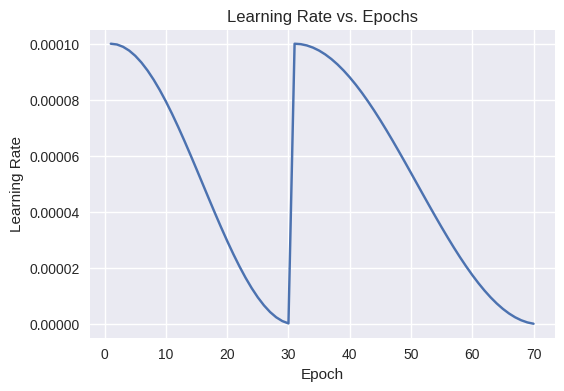

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0446, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Validation Inference Time: 2.95 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2124, Accuracy: 0.7600, Precision: 0.7665, Recall: 0.7600, F1 Score: 0.7567
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0480, Accuracy: 0.9890, Precision: 0.9890, Recall: 0.9890, F1 Score: 0.9890


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1994, Accuracy: 0.7650, Precision: 0.7617, Recall: 0.7650, F1 Score: 0.7614
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0463, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Validation Inference Time: 2.96 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2106, Accuracy: 0.7483, Precision: 0.7733, Recall: 0.7483, F1 Score: 0.7538
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0433, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.74 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2177, Accuracy: 0.7367, Precision: 0.7729, Recall: 0.7367, F1 Score: 0.7465
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0413, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2139, Accuracy: 0.7533, Precision: 0.7775, Recall: 0.7533, F1 Score: 0.7601
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0411, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.78 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2091, Accuracy: 0.7533, Precision: 0.7740, Recall: 0.7533, F1 Score: 0.7603
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0402, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2322, Accuracy: 0.7333, Precision: 0.7823, Recall: 0.7333, F1 Score: 0.7448
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0404, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.89 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2067, Accuracy: 0.7517, Precision: 0.7787, Recall: 0.7517, F1 Score: 0.7588
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0391, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Validation Inference Time: 2.75 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2030, Accuracy: 0.7550, Precision: 0.7628, Recall: 0.7550, F1 Score: 0.7579
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0396, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.86 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2501, Accuracy: 0.7000, Precision: 0.7739, Recall: 0.7000, F1 Score: 0.7173
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0389, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1949, Accuracy: 0.7550, Precision: 0.7599, Recall: 0.7550, F1 Score: 0.7571
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0370, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation Inference Time: 2.80 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2071, Accuracy: 0.7367, Precision: 0.7461, Recall: 0.7367, F1 Score: 0.7377
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0360, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Validation Inference Time: 2.90 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1950, Accuracy: 0.7767, Precision: 0.7981, Recall: 0.7767, F1 Score: 0.7828
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0345, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1940, Accuracy: 0.7667, Precision: 0.7742, Recall: 0.7667, F1 Score: 0.7659
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0336, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1951, Accuracy: 0.7650, Precision: 0.7877, Recall: 0.7650, F1 Score: 0.7715
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0336, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2115, Accuracy: 0.7483, Precision: 0.7921, Recall: 0.7483, F1 Score: 0.7591
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0323, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Validation Inference Time: 2.80 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1885, Accuracy: 0.7667, Precision: 0.7894, Recall: 0.7667, F1 Score: 0.7740
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0316, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.88 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1892, Accuracy: 0.7683, Precision: 0.7768, Recall: 0.7683, F1 Score: 0.7658
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0314, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Validation Inference Time: 2.91 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2050, Accuracy: 0.7483, Precision: 0.7609, Recall: 0.7483, F1 Score: 0.7524
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0298, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Validation Inference Time: 2.75 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2043, Accuracy: 0.7533, Precision: 0.7566, Recall: 0.7533, F1 Score: 0.7474
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0290, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2040, Accuracy: 0.7433, Precision: 0.7545, Recall: 0.7433, F1 Score: 0.7426
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0283, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2001, Accuracy: 0.7500, Precision: 0.7549, Recall: 0.7500, F1 Score: 0.7484
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0268, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2013, Accuracy: 0.7600, Precision: 0.7566, Recall: 0.7600, F1 Score: 0.7574
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0260, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Validation Inference Time: 2.91 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2042, Accuracy: 0.7550, Precision: 0.7684, Recall: 0.7550, F1 Score: 0.7592
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0266, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.86 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1975, Accuracy: 0.7600, Precision: 0.7704, Recall: 0.7600, F1 Score: 0.7629
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0246, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1940, Accuracy: 0.7567, Precision: 0.7741, Recall: 0.7567, F1 Score: 0.7630
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0242, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1883, Accuracy: 0.7583, Precision: 0.7703, Recall: 0.7583, F1 Score: 0.7614
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0232, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Validation Inference Time: 2.88 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2060, Accuracy: 0.7483, Precision: 0.7778, Recall: 0.7483, F1 Score: 0.7535
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0220, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2059, Accuracy: 0.7517, Precision: 0.7685, Recall: 0.7517, F1 Score: 0.7516
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0210, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Validation Inference Time: 2.94 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.2023, Accuracy: 0.7517, Precision: 0.7637, Recall: 0.7517, F1 Score: 0.7512
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


Train Loss: 0.0201, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Validation Inference Time: 2.89 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1983, Accuracy: 0.7533, Precision: 0.7650, Recall: 0.7533, F1 Score: 0.7544
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0194, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.03 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1975, Accuracy: 0.7583, Precision: 0.7654, Recall: 0.7583, F1 Score: 0.7577
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0183, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1982, Accuracy: 0.7617, Precision: 0.7658, Recall: 0.7617, F1 Score: 0.7582
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0179, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.82 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1944, Accuracy: 0.7583, Precision: 0.7650, Recall: 0.7583, F1 Score: 0.7586
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0165, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Validation Inference Time: 2.77 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1913, Accuracy: 0.7650, Precision: 0.7714, Recall: 0.7650, F1 Score: 0.7665
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0157, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Validation Inference Time: 2.90 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1998, Accuracy: 0.7533, Precision: 0.7692, Recall: 0.7533, F1 Score: 0.7574
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 0.0154, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1912, Accuracy: 0.7617, Precision: 0.7673, Recall: 0.7617, F1 Score: 0.7625
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0141, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.10 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1881, Accuracy: 0.7767, Precision: 0.7814, Recall: 0.7767, F1 Score: 0.7781
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0129, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.85 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1891, Accuracy: 0.7667, Precision: 0.7728, Recall: 0.7667, F1 Score: 0.7677
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0121, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Validation Inference Time: 2.79 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1919, Accuracy: 0.7667, Precision: 0.7734, Recall: 0.7667, F1 Score: 0.7670
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0111, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1937, Accuracy: 0.7733, Precision: 0.7835, Recall: 0.7733, F1 Score: 0.7751
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0104, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Validation Inference Time: 2.81 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1960, Accuracy: 0.7700, Precision: 0.7810, Recall: 0.7700, F1 Score: 0.7718
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0094, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.07 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1961, Accuracy: 0.7683, Precision: 0.7753, Recall: 0.7683, F1 Score: 0.7683
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0083, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Validation Inference Time: 3.02 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1954, Accuracy: 0.7667, Precision: 0.7743, Recall: 0.7667, F1 Score: 0.7687
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.0073, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Validation Inference Time: 2.92 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1970, Accuracy: 0.7667, Precision: 0.7754, Recall: 0.7667, F1 Score: 0.7669
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.0066, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.83 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1980, Accuracy: 0.7717, Precision: 0.7853, Recall: 0.7717, F1 Score: 0.7741
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Train Loss: 0.0053, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1938, Accuracy: 0.7717, Precision: 0.7774, Recall: 0.7717, F1 Score: 0.7710
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0047, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Validation Inference Time: 2.96 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1991, Accuracy: 0.7600, Precision: 0.7650, Recall: 0.7600, F1 Score: 0.7579
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0036, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Validation Inference Time: 2.84 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1972, Accuracy: 0.7700, Precision: 0.7800, Recall: 0.7700, F1 Score: 0.7717
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.0024, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Validation Inference Time: 2.87 sec, Peak GPU Memory: 1329.55 MB
Validation Loss: 0.1998, Accuracy: 0.7683, Precision: 0.7826, Recall: 0.7683, F1 Score: 0.7715
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Test Inference Time: 3.05 sec, Peak GPU Memory: 1408.71 MB
Test Loss: 0.1334, Accuracy: 0.7850, Precision: 0.7884, Recall: 0.7850, F1 Score: 0.7799
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       117
           1       0.86      0.88      0.87       393
           2       0.59      0.79      0.68        90

    accuracy                           0.79       600
   macro avg       0.72      0.71      0.70       600
weighted avg       0.79      0.79      0.78       600



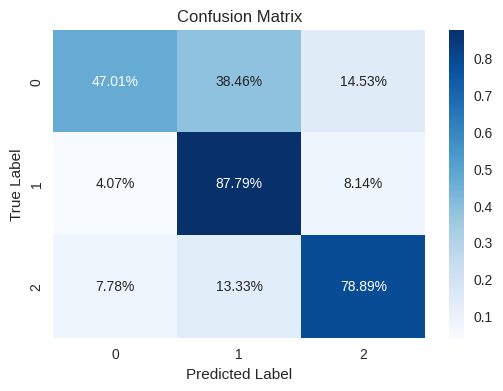

Test Sensitivity: 0.9557, Test Specificity: 0.5500


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


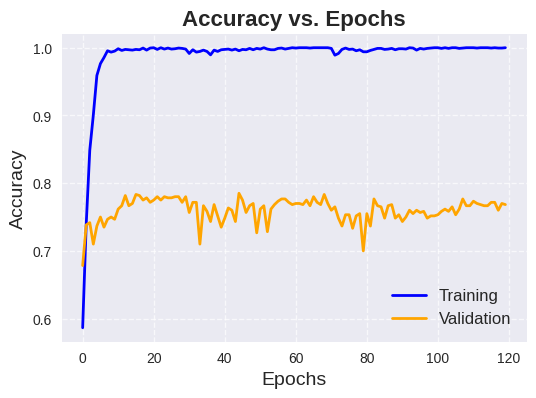

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


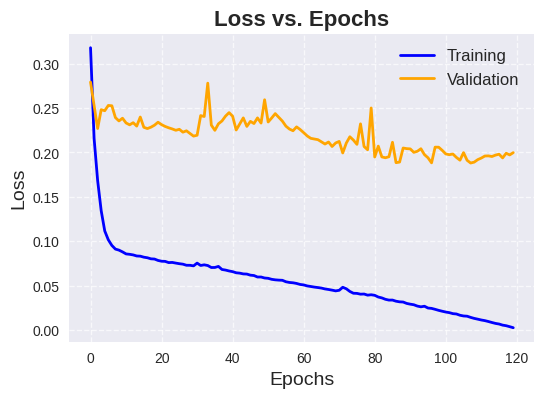

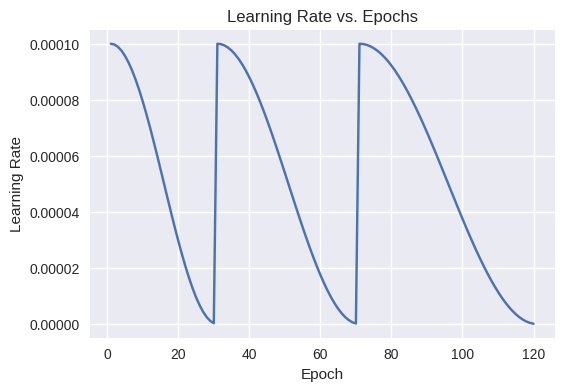

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)